Background sample : 각 class 별 0-10% 정도 권장

street-facilities-2  : Baseline
총 (test+train+val) class 0, 1, 2 object 수 (파일 갯수 x)
[2698 7672 5397]  

샘플 이미지 수 (test)  
total :  8477  
[1301, 3953, 3223]  
negative examples :  [182, 1083, 915]  
positive examples :  [1119, 2870, 2308]  

이미지당 bbox 가 몇 개 있는 지는 매번 다르지만 대략적으로  
crop, flip, rotation90 적용해서  
[class 0 , 1 , 2]  
X2, X1(가장 학습이 더딘 클래스이므로 oversampling), X1  
각 클래스별 5000 개 이상 bbox 정도를 목표  
처리 후에 분포를 다시 확인해 보기로  

데이터 분포 확인

In [3]:
import numpy as np
import os

# 둘 중 하나 선택
# label_dir = "D:/Downloads/street-facilities-selected/labels-txt" # 증강 이전 분포
label_dir = "D:/Downloads/street-facilities-selected/transformed-labels-txt" # 증강 이후 분포

labels = [label for label in os.listdir(label_dir) if label.endswith(".txt")]

file_dist = np.zeros((2,3))

object_dist = np.zeros((2,3))

mapping = {
    9 : 0,
    12 : 1,
    13 : 2,
}

total_cnt = len(labels)

for i, label in enumerate(labels):
    if i % 500 == 0:
        print(f"{i+1} / {total_cnt}")
    # 파일 분포
    subset = label.split("_")
    ctype = int(subset[1])
    state = int(subset[2])

    file_dist[state][mapping[ctype]] += 1

    # 오브젝트 분포
    label_path = os.path.join(label_dir, label)
    # 정상 오브젝트 state == 0
    if (os.path.isfile(label_path) and os.path.getsize(label_path) == 0):
        object_dist[0][mapping[ctype]] += 1
        continue
    # 불량 오브젝트 state == 1
    with open(label_path, "r+", encoding="utf-8") as f:
        for line in f:
            elems = line.split(" ")
            object_dist[1][int((elems[0]))] += 1


# 행번호 : class type
# 열번호 : 0-> 정상, 1->불량(파손)

print("파일 분포")
print(file_dist)

print("오브젝트 분포")
print(object_dist)


1 / 19556
501 / 19556
1001 / 19556
1501 / 19556
2001 / 19556
2501 / 19556
3001 / 19556
3501 / 19556
4001 / 19556
4501 / 19556
5001 / 19556
5501 / 19556
6001 / 19556
6501 / 19556
7001 / 19556
7501 / 19556
8001 / 19556
8501 / 19556
9001 / 19556
9501 / 19556
10001 / 19556
10501 / 19556
11001 / 19556
11501 / 19556
12001 / 19556
12501 / 19556
13001 / 19556
13501 / 19556
14001 / 19556
14501 / 19556
15001 / 19556
15501 / 19556
16001 / 19556
16501 / 19556
17001 / 19556
17501 / 19556
18001 / 19556
18501 / 19556
19001 / 19556
19501 / 19556
파일 분포
[[ 728. 2166. 1830.]
 [4476. 5740. 4616.]]
오브젝트 분포
[[  728.  2166.  1830.]
 [10792. 15344. 10794.]]


증강 처리

In [6]:
import os
import numpy as np
import cv2
import albumentations as A
import matplotlib.pyplot as plt
import warnings # to ignore np.loadtxt warning

warnings.filterwarnings("ignore", category=RuntimeWarning) # bbox 가 없는 객체에 대해 transform 시 runtimeWarning 발생

def tranform_data(transform,
                  image_dir,
                  label_dir,
                  image_save_dir,
                  label_save_dir,
                  iter = dict,
                  ):
    
    image_names = [f for f in os.listdir(image_dir) 
                 if f.endswith('.jpg') or f.endswith('.jpeg')] # .jpeg 도 극히 일부 존재
    
    for image_name in image_names:
        image = cv2.imread(os.path.join(image_dir, image_name))
        # 확장자명 제거한 이미지 파일이름
        f_base = os.path.splitext(image_name)[0]
        # 데이터 유형
        # 클래스 : [9 or 12 or 13]
        class_type = int(f_base.split("_")[1])
        # 상태 : 0 정상 1 불량
        state = int(f_base.split("_")[2]) 
        label_file = os.path.join(label_dir, f_base + ".txt")

        # 빈 txt 파일일 경우 뜨는 numpy 경고문 무시
        with warnings.catch_warnings():
            warnings.simplefilter("ignore") 
            ##### ** 중요 ** .json 파일로부터 작성된 labels-txt 파일(변환이전)이 있어야 함 - format_translation.ipynb
            bboxes = np.loadtxt(fname=label_file, delimiter=" ", ndmin=2)

        # albumentations 처리 형태로 변환
        bboxes = np.roll(bboxes, 4, axis=1)
        
        for i in iter[class_type]:
            # 변환
            # !! BBOX 가 없는 샘플을 transform 하면 runtime warning (아마 bbox area 가 0이 되서 그런듯 하다)
            transformed = transform(image=image, bboxes=bboxes)
            
            # 변환 결과
            trans_image = transformed["image"]
            trans_bboxes = transformed['bboxes']

            # albumentations 처리 형태에서 yolo label 형태로 다시 변환
            trans_label = np.roll(trans_bboxes, 1, axis=1)
            
            # 변환 결과 저장
            if (i > 0):
                image_save_path = os.path.join(image_save_dir, f_base + f"{-i}.jpg")
                label_save_path = os.path.join(label_save_dir, f_base + f"{-i}.txt")
            else:
                image_save_path = os.path.join(image_save_dir, f_base + ".jpg")
                label_save_path = os.path.join(label_save_dir, f_base + ".txt")

            cv2.imwrite(image_save_path, trans_image)
            np.savetxt(label_save_path, trans_label, delimiter=" ", fmt='%.8f')

In [ ]:
import os
import numpy as np
import cv2
import albumentations as A
import matplotlib.pyplot as plt
import warnings # to ignore np.loadtxt warning

# warnings.filterwarnings("ignore", category=RuntimeWarning) # bbox 가 없는 객체에 대해 transform 시 runtimeWarning 발생

root_path = "D:/Downloads/street-facilities-selected"
image_path = os.path.join(root_path, "images")
label_path = os.path.join(root_path, "labels-txt")

image_save_dir = os.path.join(root_path, "transformed-images")
label_save_dir = os.path.join(root_path, "transformed-labels-txt")

os.makedirs(image_save_dir, exist_ok=True)
os.makedirs(label_save_dir, exist_ok=True)

image_names = [f for f in os.listdir(image_path) 
                 if f.endswith('.jpg') or f.endswith('.jpeg')] # .jpeg 도 극히 일부 존재

total_cnt = len(image_names)

# 변환
# transform = A.Compose([
#         A.OneOf([ # 변환 중 하나를 확률적으로 선택. 여기서는 각각 1.0 * 1/4(변환X, 회전, 플립, 크롭) 확률로 수행됨.
#             A.NoOp(p=1), # 원본 그대로 유지 (변환x)

#             # Keypoints are rotated around the center of the image.
#             # Bounding boxes are rotated and may change size or shape.
#             # ref.https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
#             A.SafeRotate(limit=(90, 90), # Range from which a random angle is picked.
#                         border_mode=cv2.BORDER_REPLICATE, 
#                         p=1.0),
#             # Flip
#             A.HorizontalFlip(p=1.0),
#             # Random Crop
#             A.Compose([
#                 A.RandomCrop(width=160, height=160, p=1.0),
#                 A.Resize(640, 360), # height, width
#             ], p=1.0)
#         ], p=1.0)
#     ],bbox_params=A.BboxParams('yolo'))

# 1/4 확률로 원본유지/90/180/270도 회전
# 이후 모델이 학습하는 과정에서도 내부적으로 argumentation 수행
# randaugment -> 좌우/상하 flip, erasing, hsv, translation
transform2 = A.Compose([
        A.OneOf([ # 변환 중 하나를 확률적으로 선택. 여기서는 각각 1/4 확률
            A.NoOp(p=1), # 원본 그대로 유지 (변환x)

            A.SafeRotate(limit=(90, 90), # Range from which a random angle is picked.
                        border_mode=cv2.BORDER_REPLICATE, 
                        p=1.0),

            A.SafeRotate(limit=(180, 180),
            border_mode=cv2.BORDER_REPLICATE, 
            p=1.0),

            A.SafeRotate(limit=(270, 270),
            border_mode=cv2.BORDER_REPLICATE, 
            p=1.0),
        ], p=1.0)
    ],bbox_params=A.BboxParams('yolo'))

iter = {
    9 : 4,
    12 : 2,
    13 : 2,
}

# iter 에 지정된 횟수만큼 transform 수행 & 저장
tranform_data(transform2, 
              label_path,
              image_path, 
              image_save_dir, 
              label_save_dir, 
              iter=iter)

1/8477
301/8477
601/8477
901/8477
1201/8477
1501/8477
1801/8477
2101/8477
2401/8477
2701/8477
3001/8477
3301/8477
3601/8477
3901/8477
4201/8477
4501/8477
4801/8477
5101/8477
5401/8477
5701/8477
6001/8477
6301/8477
6601/8477
6901/8477
7201/8477
7501/8477
7801/8477
8101/8477
8401/8477


** 필수 ** 라벨데이터 class_id int 형으로 형변환

In [4]:
import os

root_path = "D:/Downloads/street-facilities-selected"

label_path = f"{root_path}/transformed-labels-txt"

labels = [label for label in os.listdir(label_path) if label.endswith('.txt')]
total_cnt = len(labels)

for i, label in enumerate(labels):
    if i % 1000 == 0 :
        print(f"{i+1} / {total_cnt}")
    annotations = []
    with open(os.path.join(label_path, label), "r+", encoding="utf-8") as f:
        # 기존 내용 읽기 및 수정
        for line in f:
            elems = line.split(" ")
            elems[0] = str(int(float(elems[0]))) # 1.00000000 -> 1 -> '1'
            newline = " ".join(elems)
            annotations.append(newline)
            
        # 새 내용 작성
        f.seek(0) # 파일 포인터 이동
        for annotation in annotations:
            f.write(annotation)
        f.truncate() # 파일 포인터 이전 내용만 남기고 나머지 삭제

1 / 9778
1001 / 9778
2001 / 9778
3001 / 9778
4001 / 9778
5001 / 9778
6001 / 9778
7001 / 9778
8001 / 9778
9001 / 9778


테스트

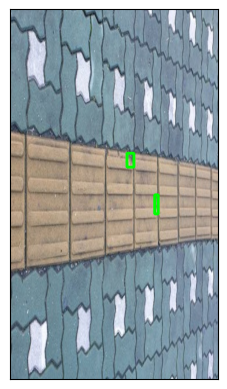

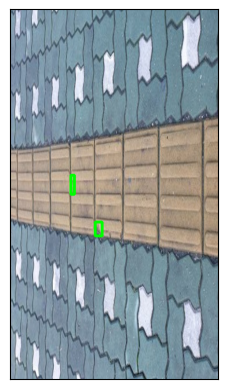

In [2]:
from PIL import Image
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

def visualize_bbox(image:np.array, bboxes: list, rgb: tuple = (0, 255, 0), thickness : int = 3):
    if len(bboxes) != 0:
        for bbox in bboxes:
            class_type = bbox[0]
            xcenter, ycenter, width, height = bbox[1:]
            xmin, xmax = xcenter - width/2, xcenter + width/2
            ymin, ymax = ycenter - height/2, ycenter + height/2
            
            h, w, _ = image.shape
            pt1 =  np.int16(np.ceil([xmin * w, ymin * h]))
            pt2 = np.int16(np.ceil([xmax * w, ymax * h]))

            image = cv2.rectangle(image, pt1, pt2, rgb, thickness)

    plt.figure()
    plt.xticks([])
    plt.yticks([])
    plt.imshow(image)

root_path = "D:/Downloads/street-facilities-selected"

image_path = f"{root_path}/transformed-images"
label_path = f"{root_path}/transformed-labels-txt"

# images = [f for f in os.listdir(image_path) if int(f.split("_")[2]) == 1 ][300:303]
# labels = [f for f in os.listdir(label_path) if int(f.split("_")[2]) == 1 ][300:303]


images = ["2_09_1_1_1_1_20210908_0000462911.jpg", "2_09_1_1_1_1_20210908_0000462911-1.jpg"]
labels = ["2_09_1_1_1_1_20210908_0000462911.txt", "2_09_1_1_1_1_20210908_0000462911-1.txt"]

total_cnt = len(labels)

for i, (label_name, image_name) in enumerate(zip(labels, images)):
    if i >= 3 : break
    bboxes = []
    with open(os.path.join(label_path, label_name), encoding='utf-8') as f:
        for line in f:
            bboxes.append(list(map(float, line.strip().split(" "))))
    image = Image.open(os.path.join(image_path, image_name))
    visualize_bbox(np.array(image), bboxes)